# Axis info metadata EDA

## Notebooks set-up|

In [1]:
# Set notebook root to project root
from helper_functions import set_project_root

set_project_root()

# Standard library imports
import itertools
import os
import random

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from astropy.stats import sigma_clip

# Local imports
import configuration as config

Working directory: /mnt/arkk/kaggle/ariel-data-challenge


## 1. Load and inspect

In [2]:
axis_info = pd.read_parquet(f'{config.DATA_DIRECTORY}/raw/axis_info.parquet')
axis_info.head()

,AIRS-CH0-axis0-h,AIRS-CH0-axis2-um,AIRS-CH0-integration_time,FGS1-axis0-h
0,0.000028,4.078463,0.1,0.000028
1,0.000056,4.074023,4.5,0.000056
2,0.001361,4.069568,0.1,0.000139
3,0.001389,4.065100,4.5,0.000167
4,0.002694,4.060618,0.1,0.000250


In [3]:
axis_info.describe()

,AIRS-CH0-axis0-h,AIRS-CH0-axis2-um,AIRS-CH0-integration_time,FGS1-axis0-h
count,11250.000000,356.000000,11250.000000,135000.000000
mean,3.749375,3.000661,2.300000,3.749986
std,2.165160,0.711864,2.200098,2.165072
min,0.000028,1.633253,0.100000,0.000028
25%,1.874701,2.407917,0.100000,1.875007
50%,3.749375,3.073674,2.300000,3.749986
75%,5.624049,3.630522,4.500000,5.624965
max,7.498722,4.078463,4.500000,7.499944


In [4]:
axis_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135000 entries, 0 to 134999
Data columns (total 4 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   AIRS-CH0-axis0-h           11250 non-null   float64
 1   AIRS-CH0-axis2-um          356 non-null     float64
 2   AIRS-CH0-integration_time  11250 non-null   float64
 3   FGS1-axis0-h               135000 non-null  float64
dtypes: float64(4)
memory usage: 4.1 MB


Ah - OK, this makes more sense now. When I saw 'axis', I was thinking of spatial alignment of the satellite, or maybe the star system? I don't know what I was picturing, but this is better. It's data for each axis of the signal matrices. Much more helpful. Here's my interpretation:

1. AIRS-CH0-axis0-h: Time index for AIRS readings - h is probably hours (0.000028 x 3600 sec per hour ~ 0.1 s)
2. AIRS-CH0-axis2-um: Wavelength across the frames in μm, the range of ~ 1.6 - μm is consistent with the high energy-ish end of the IR spectrum
3. AIRS-CH0-integration_time: Amount of time the detector had been accumulating for when read, presumably seconds
4. FGS1-axis0-h: Time index of FGS1 readings

So I think we should probably resample some FGS1 data to match the AIRS time course and see if we can still spot transits easily.

In [5]:
axis_info['FGS1-axis0-s'] = axis_info['FGS1-axis0-h'] * 3600
axis_info['AIRS-CH0-axis0-s'] = axis_info['AIRS-CH0-axis0-h'] * 3600

axis_info.head(10)

,AIRS-CH0-axis0-h,AIRS-CH0-axis2-um,AIRS-CH0-integration_time,FGS1-axis0-h,FGS1-axis0-s,AIRS-CH0-axis0-s
0,0.000028,4.078463,0.1,0.000028,0.1,0.1
1,0.000056,4.074023,4.5,0.000056,0.2,0.2
2,0.001361,4.069568,0.1,0.000139,0.5,4.9
3,0.001389,4.065100,4.5,0.000167,0.6,5.0
4,0.002694,4.060618,0.1,0.000250,0.9,9.7
5,0.002722,4.056122,4.5,0.000278,1.0,9.8
6,0.004028,4.051612,0.1,0.000361,1.3,14.5
7,0.004056,4.047089,4.5,0.000389,1.4,14.6
8,0.005361,4.042552,0.1,0.000472,1.7,19.3
9,0.005389,4.038000,4.5,0.000500,1.8,19.4


## 2. Exposure time series

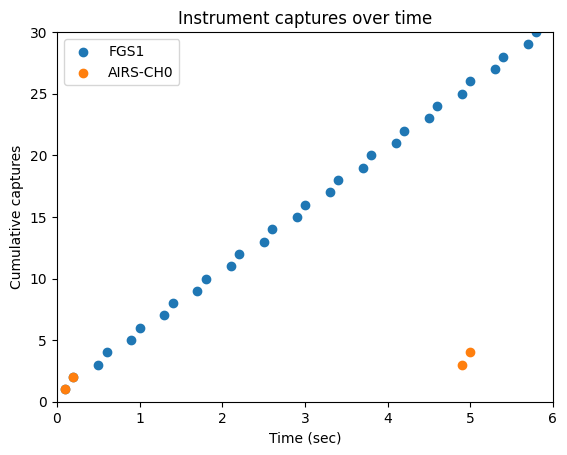

In [6]:
plt.title('Instrument captures over time')
plt.scatter(axis_info['FGS1-axis0-h'] * 3600, list(range(1, len(axis_info['FGS1-axis0-h']) + 1)), label='FGS1')
plt.scatter(axis_info['AIRS-CH0-axis0-h'] * 3600, list(range(1, len(axis_info['AIRS-CH0-axis0-h']) + 1)), label='AIRS-CH0')
plt.xlim(0, 6)
plt.ylim(0, 30)
plt.xlabel('Time (sec)')
plt.ylabel('Cumulative captures')
plt.legend(loc='best')
plt.savefig('figures/EDA/01.5-captures_over_time.jpg', dpi=config.STD_FIG_DPI, bbox_inches='tight')
plt.show()

You can clearly see the correlated double sampling exposure pairs for each instrument. The first read at t=+0.1 collects photons from the first 0.1 seconds for both instruments. Then, 0.1 seconds later we start the first capture of the first CDS pair for both instruments at t=+0.2. AIRS accumulates for 4.5 seconds and reads at t=+4.7. It then starts accumulating again at t=+4.8 and reads at t=+4.9, starts accumulating again at t=+5.0 and reads at t=+9.5, etc. The FGS accumulates for 0.2 seconds and reads at t=+0.4, starts accumulating again at t=+0.5, reads again at t=+0.6, starts accumulating again at t=+0.7, reads again at t=+0.9. This whole thing is made confusing by the fact that the time reported for the first (short) sub exposure of a CDS pair is the end of the collection period, while the time reported for the second (long) sub exposure is the start of the collection period.

The [description of CDS](https://www.kaggle.com/code/gordonyip/calibrating-and-binning-ariel-data?scriptVersionId=247643997&cellId=25) given in the [preprocessing notebook](https://www.kaggle.com/code/gordonyip/calibrating-and-binning-ariel-data) says to subtract the sub exposures. Though the description of which order to subtract them in seems to contradict the description given in the [dataset description](https://www.kaggle.com/competitions/ariel-data-challenge-2025/data). This is making my head spin. The second exposure should be longer according to the axis info, but looking at the AIRS data the first frame always has higher signal that then second. Let's just load up a planet and start trying things.

In [7]:
planets = list(os.listdir(f'{config.RAW_DATA_DIRECTORY}/train'))
random_planet = planets[random.randint(0, len(planets)-1)]

airs_file = f'{config.RAW_DATA_DIRECTORY}/train/{random_planet}/AIRS-CH0_signal_0.parquet'
fgs_file = f'{config.RAW_DATA_DIRECTORY}/train/{random_planet}/FGS1_signal_0.parquet'

print(f'Example AIRS-CH0 signal file path: {airs_file}')
print(f'Example FGS1 signal file path: {fgs_file}')

Example AIRS-CH0 signal file path: ./data/raw/train/3019441199/AIRS-CH0_signal_0.parquet
Example FGS1 signal file path: ./data/raw/train/3019441199/FGS1_signal_0.parquet


In [8]:
airs_signal = pd.read_parquet(airs_file).to_numpy().reshape(11250, 32, 356)

cut_inf, cut_sup = 39, 321
airs_signal = airs_signal[:, :, cut_inf:cut_sup]

print(f'Raw AIRS signal shape: {airs_signal.shape}')
print(f'Raw AIRS frame shape: {airs_signal[0].shape}')

Raw AIRS signal shape: (11250, 32, 282)
Raw AIRS frame shape: (32, 282)


In [9]:
# Read the Parquet file into a PyArrow Table
fgs_signal = pd.read_parquet(fgs_file).to_numpy().reshape(135000, 32, 32)
print(f'Raw FGS signal shape: {fgs_signal.shape}')
print(f'Raw FGS frame shape: {fgs_signal[0].shape}')

Raw FGS signal shape: (135000, 32, 32)
Raw FGS frame shape: (32, 32)


In [10]:
def get_cds(signal):
    cds = signal[1::2,:,:] - signal[::2,:,:]
    return cds

In [11]:
airs_cds_signal = get_cds(airs_signal)
fgs_cds_signal = get_cds(fgs_signal)

In [12]:
print(f'AIRS CDS signal shape: {airs_cds_signal.shape}')
print(f'AIRS CDS frame shape: {airs_cds_signal[0].shape}')

AIRS CDS signal shape: (5625, 32, 282)
AIRS CDS frame shape: (32, 282)


In [13]:
print(f'FGS CDS signal shape: {fgs_cds_signal.shape}')
print(f'FGS CDS frame shape: {fgs_cds_signal[0].shape}')

FGS CDS signal shape: (67500, 32, 32)
FGS CDS frame shape: (32, 32)


So far so good - we have exactly half as many frames for both instruments, but the individual frame shapes have not changed.

In [14]:
np.mean(airs_cds_signal[0])

1882.8544991134752

In [15]:
np.mean(airs_cds_signal[-1])

1874.5606161347519

In [16]:
np.mean(fgs_cds_signal[0])

21116.556640625

In [17]:
np.mean(fgs_cds_signal[-1])

19261.7802734375

And it looks like we have positive values in both the AIRS and FGS signals, which is a good sign that we are subtracting correctly. Let's plot.

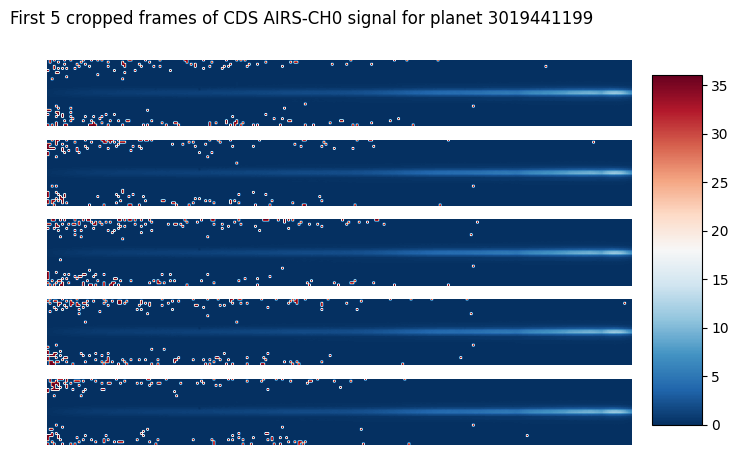

In [18]:
# Plot the first few frames
n_frames = 5
fig, axs = plt.subplots(n_frames, 1, figsize=(10, n_frames))
axs = axs.flatten()

fig.suptitle(f'First {n_frames} cropped frames of CDS AIRS-CH0 signal for planet {random_planet}')

for i in range(n_frames):
    frame = airs_cds_signal[i]        
    frame = frame.astype(float) / np.mean(frame.astype(float))
    im = axs[i].imshow(frame, cmap='RdBu_r')
    axs[i].axis('off')

fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

# fig.tight_layout()
fig.savefig('figures/EDA/01.5-uncorrected_AIRS_CDS_sample_frames.jpg', dpi=config.STD_FIG_DPI, bbox_inches='tight')

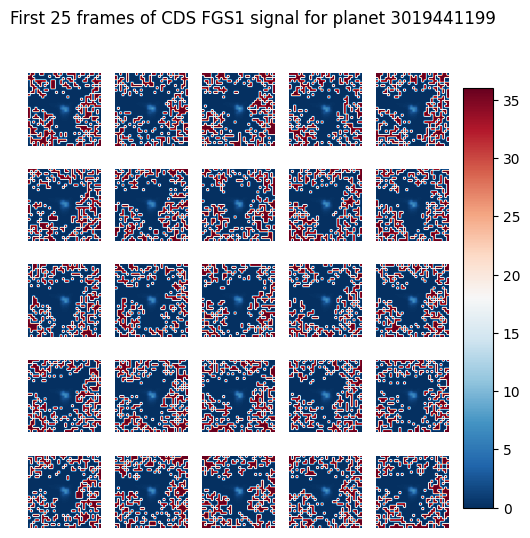

In [19]:
# Plot the first few frames
n_frames = 25
n_dim = int(n_frames**0.5)
dim = n_dim * 2
fig, axs = plt.subplots(n_dim, n_dim, figsize=(config.STD_FIG_WIDTH, config.STD_FIG_WIDTH))
axs = axs.flatten()

fig.suptitle(f'First {n_frames} frames of CDS FGS1 signal for planet {random_planet}')

for i in range(n_frames):
    frame = fgs_cds_signal[i]        
    frame = frame.astype(float) / np.mean(frame.astype(float))
    axs[i].imshow(frame, cmap='RdBu_r')
    axs[i].axis('off')

fig.subplots_adjust(right=0.825)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig.savefig('figures/EDA/01.5-uncorrected_FGS1_CDS_sample_frames.jpg', dpi=config.STD_FIG_DPI, bbox_inches='tight')

OK, so the signal looks much more constant, which is good - but now we get a lot of background noise as well. This makes some sense to me - we know that the response is not linear so during the exposure the background comes up more than the signal does. For this to work, I think we need to do the rest of the corrections as well. Here is the list:

1. Analog-to-Digital Conversion
2. Mask hot/dead pixel
3. Linearity Correction
4. Dark current subtraction
5. Get Correlated Double Sampling (CDS)
6. Flat Field Correction

Here goes...

## 3. Preprocessing for CDS recovery

### 3.1. Analog-to-Digital Conversion

Here are the ADC values from the `adc_info.csv` data file:

```
FGS1_adc_offset,FGS1_adc_gain,AIRS-CH0_adc_offset,AIRS-CH0_adc_gain
-1000.0,0.4369,-1000.0,0.4369
```

In [20]:
def ADC_convert(signal, gain=0.4369, offset=-1000):

    signal = signal.astype(np.float64)
    signal /= gain
    signal += offset

    return signal

In [21]:
airs_signal = ADC_convert(airs_signal)
fgs_signal = ADC_convert(fgs_signal)

### 3.2. Hot/dead pixel mask

In [22]:
def mask_hot_dead(signal, dead, dark):

    hot = sigma_clip(
        dark, sigma=5, maxiters=5
    ).mask
    
    hot = np.tile(hot, (signal.shape[0], 1, 1))
    dead = np.tile(dead, (signal.shape[0], 1, 1))
    signal = np.ma.masked_where(dead, signal)
    signal = np.ma.masked_where(hot, signal)

    return signal

In [23]:
planet_path = f'{config.RAW_DATA_DIRECTORY}/train/{random_planet}'

dark_airs = pd.read_parquet(f'{planet_path}/AIRS-CH0_calibration_0/dark.parquet').values.astype(np.float64).reshape((32, 356))[:, cut_inf:cut_sup]
dead_airs = pd.read_parquet(f'{planet_path}/AIRS-CH0_calibration_0/dead.parquet').values.astype(np.float64).reshape((32, 356))[:, cut_inf:cut_sup]
dark_fgs = pd.read_parquet(f'{planet_path}/FGS1_calibration_0/dark.parquet').values.astype(np.float64).reshape((32, 32))
dead_fgs = pd.read_parquet(f'{planet_path}/FGS1_calibration_0/dead.parquet').values.astype(np.float64).reshape((32, 32))

In [24]:
airs_signal = mask_hot_dead(airs_signal, dead_airs, dark_airs)
fgs_signal = mask_hot_dead(fgs_signal, dead_fgs, dark_fgs)

### 3.3. Linearity correction

In [25]:
def apply_linear_corr(linear_corr, clean_signal):
    
    linear_corr = np.flip(linear_corr, axis=0)
    
    for x, y in itertools.product(
                range(clean_signal.shape[1]), range(clean_signal.shape[2])
            ):
        poli = np.poly1d(linear_corr[:, x, y])
        clean_signal[:, x, y] = poli(clean_signal[:, x, y])

    return clean_signal

In [26]:
airs_linear_corr = pd.read_parquet(f'{planet_path}/AIRS-CH0_calibration_0/linear_corr.parquet').values.astype(np.float64).reshape((6, 32, 356))[:, :, cut_inf:cut_sup]
linear_corr = pd.read_parquet(f'{planet_path}/FGS1_calibration_0/linear_corr.parquet').values.astype(np.float64).reshape((6, 32, 32))

In [27]:
airs_signal = apply_linear_corr(airs_linear_corr, airs_signal)
fgs_signal = apply_linear_corr(linear_corr, fgs_signal)

### 3.4. Dark current subtraction

In [28]:
def clean_dark(signal, dead, dark, dt):

    dark = np.ma.masked_where(dead, dark)
    dark = np.tile(dark, (signal.shape[0], 1, 1))

    signal -= dark* dt[:, np.newaxis, np.newaxis]

    return signal

In [29]:
dt_airs = axis_info['AIRS-CH0-integration_time'].dropna().values
dt_airs[1::2] += 0.1 # Why are we adding here - I don't think that is right...

dt_fgs = np.ones(len(fgs_signal))*0.1
dt_fgs[1::2] += 0.1 # This one looks more correct

Gotta double check my reading of the exposure kinetics again...

In [30]:
airs_signal = clean_dark(airs_signal, dead_airs, dark_airs, dt_airs)
fgs_signal = clean_dark(fgs_signal, dead_fgs, dark_fgs, dt_fgs)

### 3.5. Get Correlated Double Sampling (CDS)

In [31]:
airs_signal = get_cds(airs_signal)
fgs_signal = get_cds(fgs_signal)

### 3.6. Flat field correction

In [32]:
def correct_flat_field(flat, dead, signal):

    flat = flat.transpose(1, 0)
    dead = dead.transpose(1, 0)
    flat = np.ma.masked_where(dead, flat)
    flat = np.tile(flat, (signal.shape[0], 1, 1))
    signal = signal / flat

    return signal

In [33]:
airs_flat = pd.read_parquet(f'{planet_path}/AIRS-CH0_calibration_0/flat.parquet').values.astype(np.float64).reshape((32, 356))[:, cut_inf:cut_sup]
fgs_flat = pd.read_parquet(f'{planet_path}/FGS1_calibration_0/flat.parquet').values.astype(np.float64).reshape((32, 32))

In [34]:
airs_signal = airs_signal.transpose(0,2,1)
fgs_signal = fgs_signal.transpose(0,2,1)

airs_signal = correct_flat_field(airs_flat, dead_airs, airs_signal)
fgs_signal = correct_flat_field(fgs_flat, dead_fgs, fgs_signal)

airs_signal = airs_signal.transpose(0,2,1)
fgs_signal = fgs_signal.transpose(0,2,1)

OK, *now* plot...

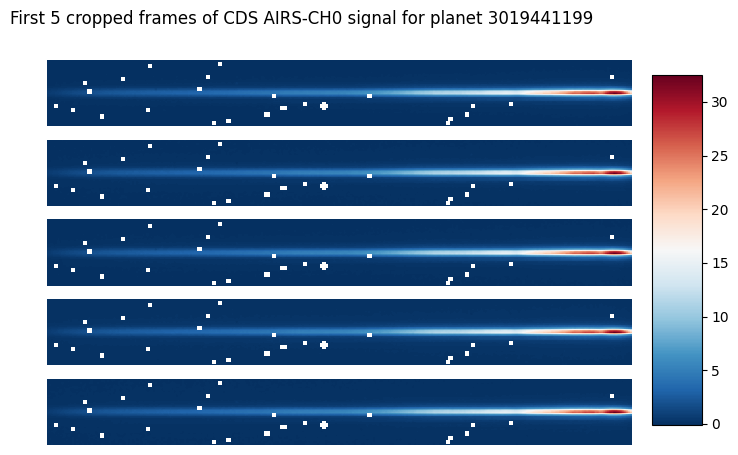

In [35]:
# Plot the first few frames
n_frames = 5
fig, axs = plt.subplots(n_frames, 1, figsize=(10, n_frames))
axs = axs.flatten()

fig.suptitle(f'First {n_frames} cropped frames of CDS AIRS-CH0 signal for planet {random_planet}')

for i in range(n_frames):
    frame = airs_signal[i]        
    frame = frame.astype(float) / np.mean(frame.astype(float))
    im = axs[i].imshow(frame, cmap='RdBu_r')
    axs[i].axis('off')

fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

# fig.tight_layout()
fig.savefig('figures/EDA/01.5-corrected_AIRS_CDS_sample_frames.jpg', dpi=config.STD_FIG_DPI, bbox_inches='tight')

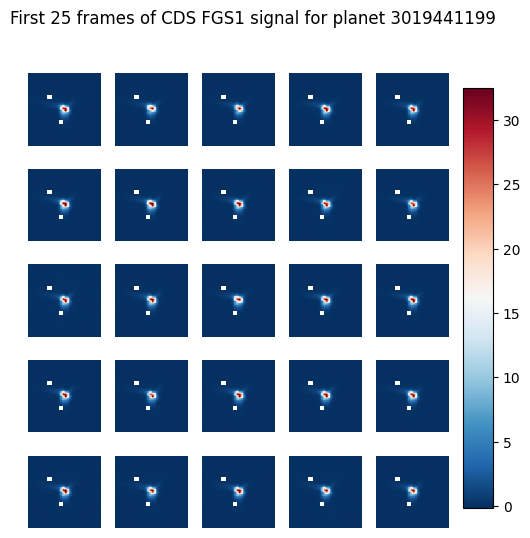

In [36]:
# Plot the first few frames
n_frames = 25
n_dim = int(n_frames**0.5)
dim = n_dim * 2
fig, axs = plt.subplots(n_dim, n_dim, figsize=(config.STD_FIG_WIDTH, config.STD_FIG_WIDTH))
axs = axs.flatten()

fig.suptitle(f'First {n_frames} frames of CDS FGS1 signal for planet {random_planet}')

for i in range(n_frames):
    frame = fgs_signal[i]        
    frame = frame.astype(float) / np.mean(frame.astype(float))
    axs[i].imshow(frame, cmap='RdBu_r')
    axs[i].axis('off')

fig.subplots_adjust(right=0.825)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig.savefig('figures/EDA/01.5-corrected_FGS1_CDS_sample_frames.jpg', dpi=config.STD_FIG_DPI, bbox_inches='tight')

Much better! Those blobs are the hot/dead pixels that have been masked out. How does the transit look in the FGS data?

## 5. Exoplanet transits

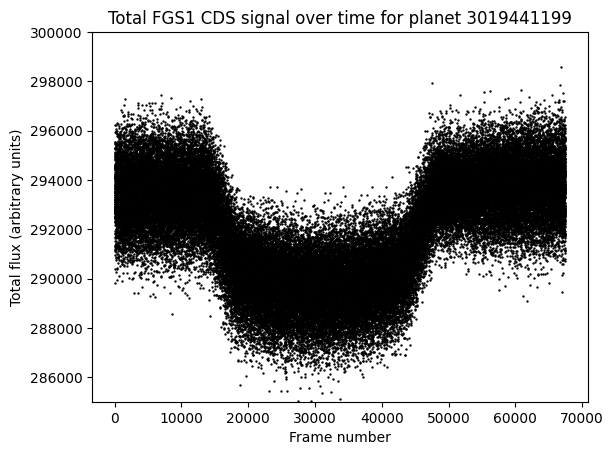

In [37]:
total_flux = [np.sum(frame) for frame in fgs_signal]

plt.title(f'Total FGS1 CDS signal over time for planet {random_planet}')
plt.scatter(list(range(len(total_flux))), total_flux, color='black', s=0.5)
plt.xlabel('Frame number')
plt.ylabel('Total flux (arbitrary units)')
plt.ylim(285000, 300000)
plt.savefig('figures/EDA/01.5-corrected_FGS_CDS_transit.jpg', dpi=config.STD_FIG_DPI, bbox_inches='tight')
plt.show()

What about the AIRS data?

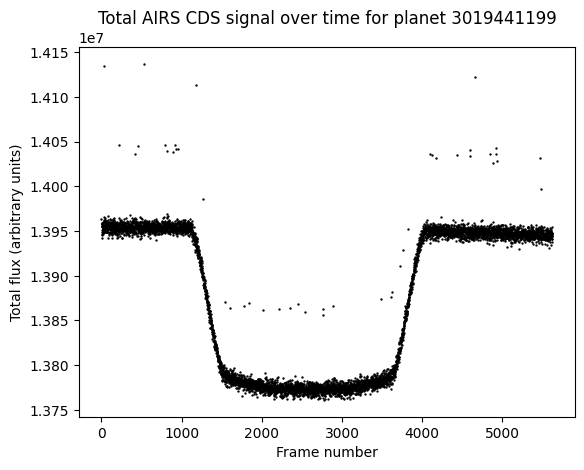

In [38]:
total_flux = [np.sum(frame) for frame in airs_signal]

plt.title(f'Total AIRS CDS signal over time for planet {random_planet}')
plt.scatter(list(range(len(total_flux))), total_flux, color='black', s=0.5)
plt.xlabel('Frame number')
plt.ylabel('Total flux (arbitrary units)')
plt.savefig('figures/EDA/01.5-corrected_AIRS_CDS_transit.jpg', dpi=config.STD_FIG_DPI, bbox_inches='tight')
plt.show()

Nice! Better than expected. I thought it would be harder to spot the transit in the FGS data. But it's cleaner than the FGS trace. I guess it is a science instrument, not just an alignment camera...

## 6. Summary

Now my concern is time. The six step preprocessing pipeline takes a long time for one planet. We can easily parallelize it - but the Kaggle notebook that we will have to run in only has 4 cores. The good news is we clearly don't need to take the extra step of using the FGS data as a proxy to spot the transit and then get the corresponding time points from the AIRS data. Still thinking we should down sample the FGS data so we have matched time series.

Here's the new plan:

1. Refactor the preprocessing - I think we should be looking at one module for upload to Kaggle to keep the final notebook clean and things simple-ish (the other crazy idea is to make it an installable package on PyPI...).
2. Re-sample the FGS data and keep only time points that are also represented in the AIRS data. It's not like we are going to miss the transit or something, and it will cut the amount of data way down. The example preprocessing function uses binning with sum - but I don't like that.
3. Figure out how to reliably crop the signals out.
4. Figure out how to select a transit and non-transit window from each time series for normalization

Profit? Note: 2, 3, and/or 4 could be done first in the pipeline. They each will reduce the amount of data significantly and in turn speed up the rest of the preprocessing. But, it may be harder to select signal or transits from the un-corrected data. Will have to think about order of operations a bit more as we see each step take shape.